In [1176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os

class MetricsAnalyzer:
    def __init__(self, halstead_path, loc_path, cc_path):
        self.halstead_path = halstead_path
        self.loc_path = loc_path
        self.cc_path = cc_path
        self.df_master = self._build_master_dataframe()
        self.color_map = self._build_color_map()

    def _clean_algorithm_name(self, name):
        return re.sub(r"^\d{2}[-_]", "", name)

    def _build_color_map(self, palette_name="Set3"):
        palette = sns.color_palette(palette_name, n_colors=10)
        languages = ["cirq", "qapl", "qiskit", "qrisp", "qmod", "q#", "qasm", "classic"]
        return {lang: palette[i % len(palette)] for i, lang in enumerate(languages)}

    def _build_master_dataframe(self):
        # Cargar todos los archivos
        halstead_df = pd.read_csv(self.halstead_path, index_col=0)
        loc_df = pd.read_csv(self.loc_path, index_col=0)
        cc_df = pd.read_csv(self.cc_path, index_col=0)
        # Renombrar la columna 'Directory' a 'Language' antes de cualquier uso
        halstead_df.rename(columns={"Directory": "Language"}, inplace=True)
        # Transformar LOC y CC a formato largo (long format)
        loc_melted = loc_df.reset_index().melt(id_vars="index", var_name="Algorithm", value_name="LOC")
        loc_melted.rename(columns={"index": "Language"}, inplace=True)

        cc_melted = cc_df.reset_index().melt(id_vars="index", var_name="Algorithm", value_name="CC")
        cc_melted.rename(columns={"index": "Language"}, inplace=True)
        # Limpiar nombres de algoritmos
        loc_melted["Algorithm"] = loc_melted["Algorithm"].apply(self._clean_algorithm_name)
        cc_melted["Algorithm"] = cc_melted["Algorithm"].apply(self._clean_algorithm_name)
        # Unir LOC y CC
        metrics_df = pd.merge(loc_melted, cc_melted, on=["Algorithm", "Language"], how="outer")
        # Limpiar nombres de algoritmos en Halstead
        halstead_df["Algorithm"] = halstead_df["File Name"].apply(
            lambda x: self._clean_algorithm_name(re.sub(r".*?/", "", x).replace(".py", ""))
        )
        halstead_metrics = halstead_df[
            ["Algorithm", "Language", "Vocabulary", "Length", "Volume", "Difficulty", "Effort"]
        ]
        master_df = pd.merge(metrics_df, halstead_metrics, on=["Algorithm", "Language"], how="left")
        return master_df


    def filter_data(self, language_type="all"):
        lang_map = {
            "hosted": ["cirq", "qapl", "qiskit", "qrisp"],
            "standalone": ["q#", "qmod"],
            "all": ["cirq", "qapl", "qiskit", "qrisp", "q#", "qmod"]
        }
        return self.df_master[self.df_master["Language"].isin(lang_map[language_type])].copy()

    def plot_metric_by(self, df, metric="LOC", by="Algorithm", agg="mean", attributes: dict=None):
        if by == "Language":
            df_plot = df.groupby("Language")[metric].agg(agg).reset_index()
        else:
            df_plot = df.groupby([by, "Language"])[metric].agg(agg).reset_index()            
        df_plot = df_plot.sort_values(by=metric, ascending=True)
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        sns.barplot(data=df_plot, x=by, y=metric, hue="Language", palette=self.color_map)
        plt.title(attributes.get("title", ""), fontsize=20)
        plt.xlabel(attributes.get("xlabel", "") , fontsize=16)
        plt.ylabel(attributes.get("ylabel", ""), fontsize=16)
        plt.xticks(rotation=45, fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(title="Programming Language", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=16, 
        title_fontsize=16 )
        plt.tight_layout()

        title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+title+".png")
        plt.show()

    
    def plot_average_metric_by_language(self, df, metric="LOC", agg="mean", attributes: dict = None):
        if attributes is None:
            attributes = {}
        df_plot = df.groupby("Language")[metric].agg(agg).reset_index()
        df_plot = df_plot.sort_values(by=metric, ascending=True)
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)
        plt.title(attributes.get("title", f"Average {metric} per Language"), fontsize=20)
        plt.xlabel(attributes.get("xlabel", "Programming Language"), fontsize=16)
        plt.ylabel(attributes.get("ylabel", f"Average {metric}"), fontsize=16)
        plt.xticks(rotation=45, fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+title+".png")
        plt.show()


    def plot_loc_vs_cc(self, df, agg="mean", title="Lines of Code vs Cyclomatic Complexity"):
        df_plot = df.groupby("Language")[["LOC", "CC"]].agg(agg).reset_index()
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df_plot, x="LOC", y="CC", hue="Language", palette=self.color_map, s=100)
        for i in range(df_plot.shape[0]):
            plt.text(df_plot["LOC"][i]+0.3, df_plot["CC"][i], df_plot["Language"][i])
        
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(title)
        plt.tight_layout()
        #title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+title+".png")
        plt.show()

    def plot_radar_chart(self, df, attributes):
        halstead_metrics = ["Vocabulary", "Length", "Volume", "Difficulty", "Effort", "LOC", "CC"]
        df_grouped = df.groupby("Language")[halstead_metrics].mean()
        df_normalized = self.normalize_metrics(df_grouped, columns=halstead_metrics)        
        df_normalized = df_normalized.select_dtypes(include=[np.number])
        labels = df_normalized.columns.tolist()
        num_vars = len(labels)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        for idx, row in df_normalized.iterrows():
            values = row.tolist()
            values += values[:1]
            ax.plot(angles, values, label=idx, linewidth=2)
            ax.fill(angles, values, alpha=0.1)
        ax.set_title(attributes.get("title", ""), size=15, y=1.1)
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
        plt.tight_layout()
        title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+title+".png")
        plt.show()
    def normalize_metrics(self, df, columns):
        return ((df[columns] - df[columns].mean()) / df[columns].std()).add(5).div(10)
    

    def plot_scatter_grid_metrics(self, df, attributes=None):
        if attributes is None:
            attributes = {}

        df_grouped = df.groupby("Language")[
            ["LOC", "CC", "Vocabulary", "Length", "Volume", "Difficulty", "Effort"]
        ].mean().reset_index()

        # Filter out unwanted languages
        df_grouped = df_grouped[~df_grouped["Language"].isin(["qasm", "classic"])]

        metric_pairs = [
            ("LOC", "CC"),
            ("Vocabulary", "Effort"),
            ("Vocabulary", "LOC"),
            ("Effort", "CC"),
            ("Volume", "LOC"),
            ("Difficulty", "CC"),
            ("Volume", "Effort"),
            ("Vocabulary", "Volume"),
            ("Length", "Difficulty")
        ]

        cols = 3
        rows = (len(metric_pairs) + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(18, 5 * rows))
        axs = axs.flatten()

        for i, (x, y) in enumerate(metric_pairs):
            ax = axs[i]
            sns.scatterplot(data=df_grouped, x=x, y=y, hue="Language", s=100, ax=ax)
            for j in range(df_grouped.shape[0]):
                ax.text(df_grouped[x].iloc[j] + 0.5, df_grouped[y].iloc[j], df_grouped["Language"].iloc[j], fontsize=9)
            ax.set_title(f"{x} vs {y}", fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.6)

        # Remove any empty subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        save_path = "results/graphics/10_scatter_matrix_metrics.png"
        self.save_plot(save_path)
        plt.show()


    

    def save_plot(self, save_path):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Plot saved at: {save_path}")


    def run(self, language_type="all", chart_type=["loc_by_algorithm"], attributes=None):
        if isinstance(chart_type, str):
            chart_type = [chart_type]
        if attributes is None:
            attributes = {}
        df = self.filter_data(language_type)
        for chart in chart_type:
            if chart == "loc_by_algorithm":
                self.plot_metric_by(df, metric="LOC", by="Algorithm", attributes=attributes)
            elif chart == "cc_by_algorithm":
                self.plot_metric_by(df, metric="CC", by="Algorithm", attributes=attributes)
            elif chart == "loc_avg_by_algorithm":
                self.plot_average_metric_by_language(df, metric="LOC", attributes=attributes)
            elif chart == "cc_avg_by_algorithm":
                self.plot_average_metric_by_language(df, metric="CC", attributes=attributes)
            elif chart == "loc_by_language":
                self.plot_metric_by(df, metric="LOC", by="Language", attributes=attributes)
            elif chart == "cc_by_language":
                self.plot_metric_by(df, metric="CC", by="Language", attributes=attributes)
            elif chart == "loc_vs_cc":
                self.plot_loc_vs_cc(df, title=attributes.get("title", ""))
            elif chart == "radar":
                self.plot_radar_chart(df, attributes=attributes)
            elif chart == "scatter_matrix":
                self.plot_scatter_grid_metrics(df)



In [1177]:
analyzer = MetricsAnalyzer(
    halstead_path="results/halstead.csv",
    loc_path="results/loc.csv",
    cc_path="results/cyclomatic_complexity_calculator.csv"
)

analyzer._build_master_dataframe()

#analyzer.run(language_type="hosted", chart_type=["loc_by_algorithm", "loc_vs_cc"])


,Language,Algorithm,LOC,CC,Vocabulary,Length,Volume,Difficulty,Effort
0,cirq,deutch-jotza,24,21,34,162,824.168980,40.000000,32966.759211
1,classic,deutch-jotza,16,11,32,75,375.000000,3.362069,1260.775862
2,q#,deutch-jotza,33,6,42,127,684.824313,42.300000,28968.068427
3,qapl,deutch-jotza,35,3,46,150,828.534293,34.000000,28170.165976
4,qasm,deutch-jotza,14,1,7,42,117.908907,18.750000,2210.792001
5,qiskit,deutch-jotza,23,16,30,98,480.875278,35.961538,17293.014818
6,qmod,deutch-jotza,29,9,24,72,330.117300,17.769231,5865.930486
7,qrisp,deutch-jotza,21,10,29,76,369.206556,22.500000,8307.147502
8,cirq,grover,44,36,44,296,1615.991759,88.933333,143715.533777
9,classic,grover,13,5,27,65,309.067688,7.000000,2163.473813


Plot saved at: results/graphics/Lines of Code by Algorithm in Quantum Programming Languages.png


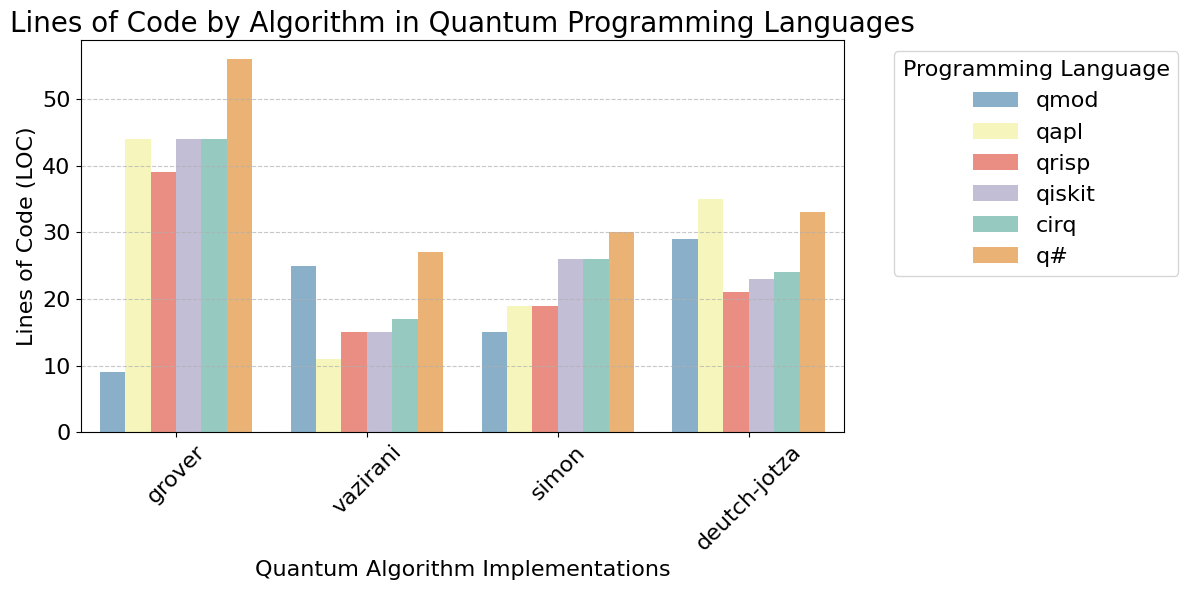

Plot saved at: results/graphics/Cyclomatic Complexity by Algorithm in Quantum Programming Languages.png


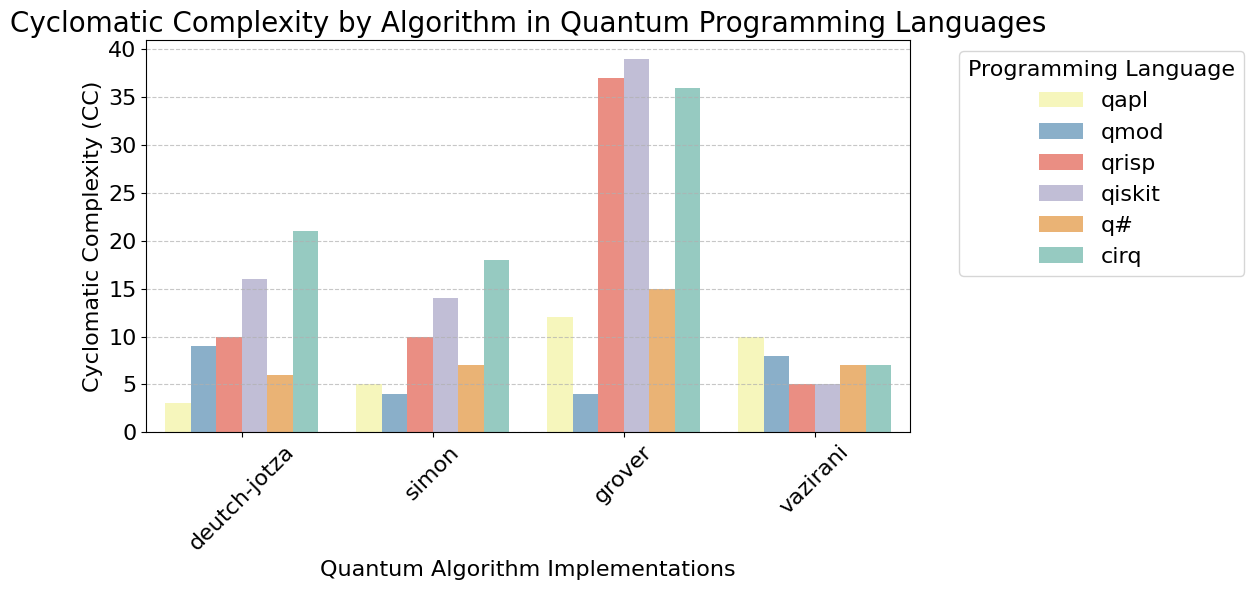

Plot saved at: results/graphics/Lines of Code by Algorithm Across Hosted Quantum Programming Languages.png


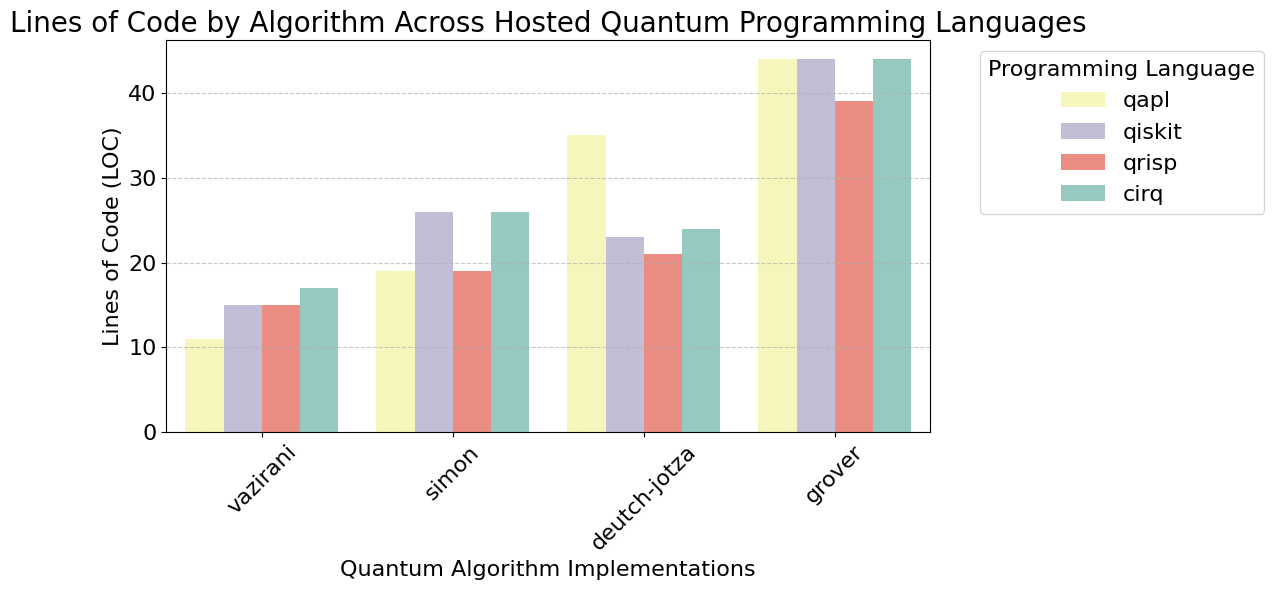

Plot saved at: results/graphics/Lines of Code by Algorithm Across Standalone Quantum Programming Languages.png


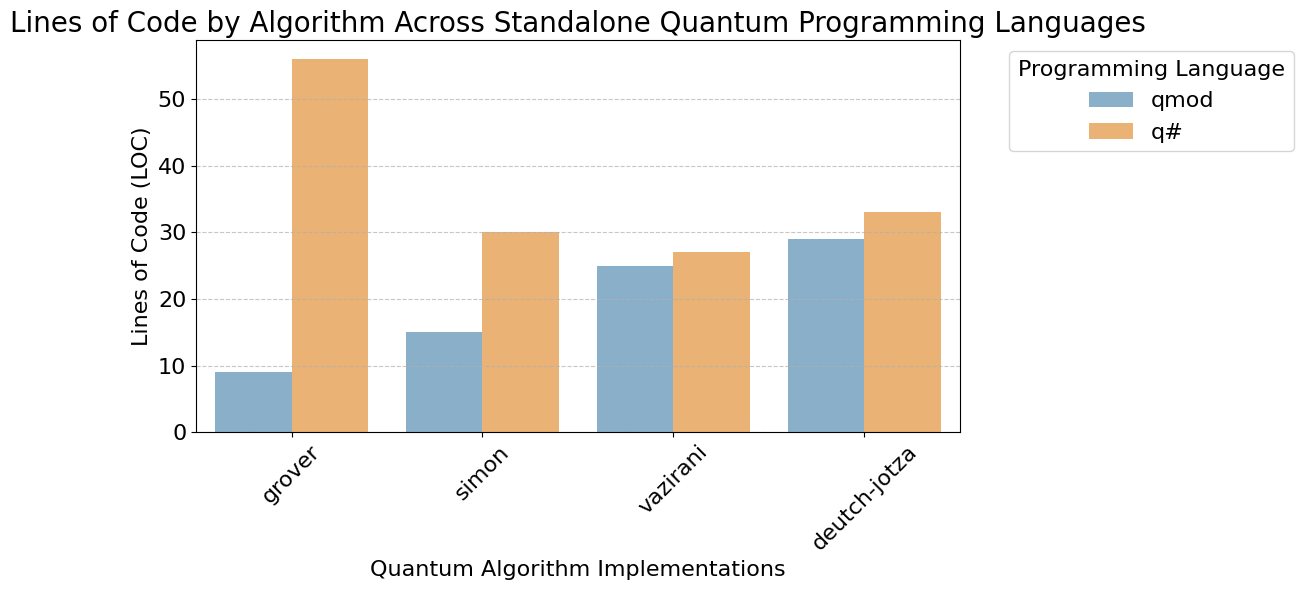

Plot saved at: results/graphics/Cyclomatic Complexity by Algorithm  Across Hosted Quantum Programming Languages.png


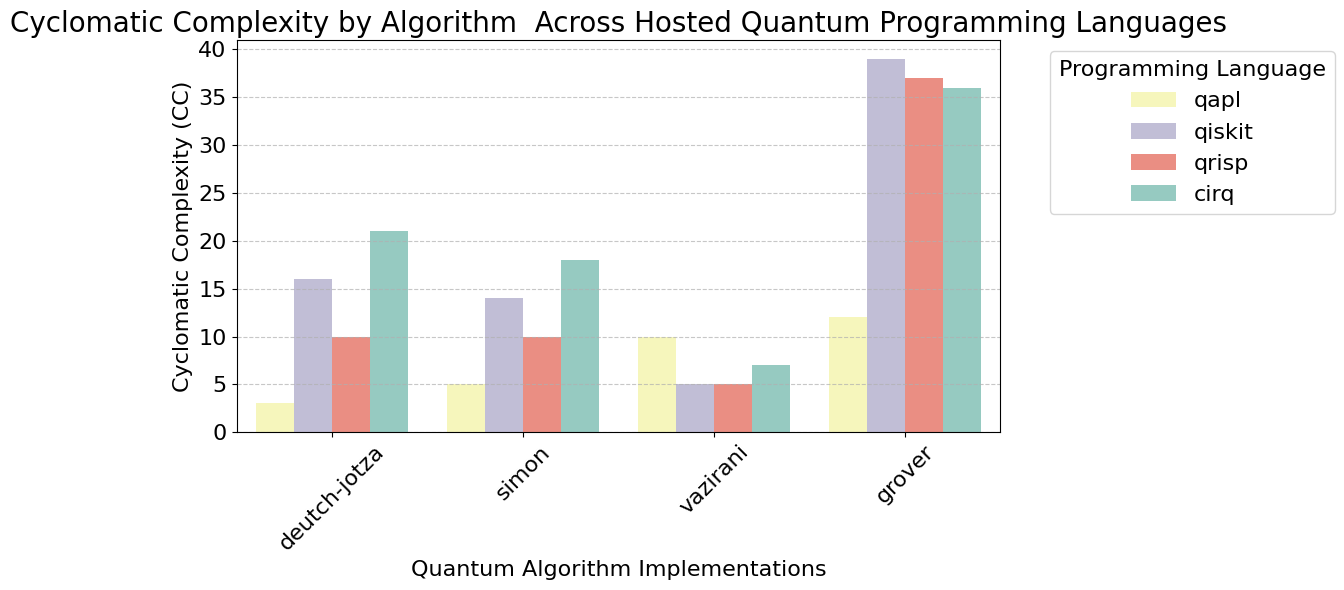

Plot saved at: results/graphics/Cyclomatic Complexity by Algorithm Across Standalone Quantum Programming Languages.png


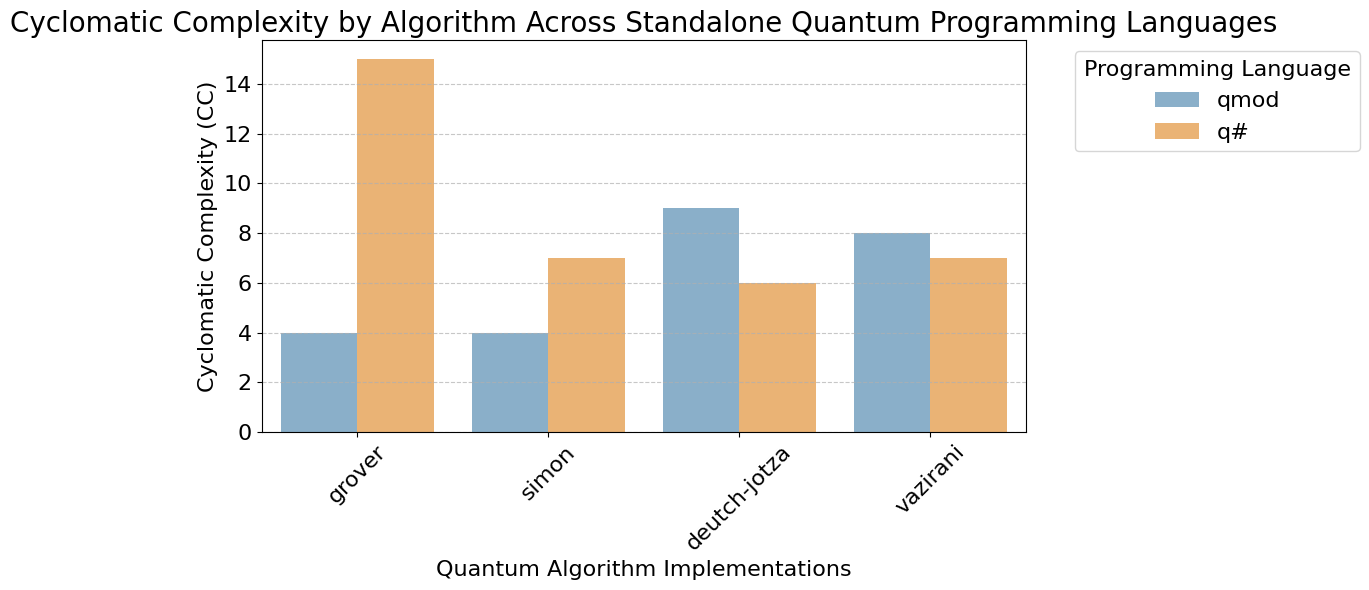

Plot saved at: results/graphics/Average Lines of Code by Algorithm Across Hosted Quantum Programming Languages.png


C:\Users\franc\AppData\Local\Temp\ipykernel_29980\1368862335.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


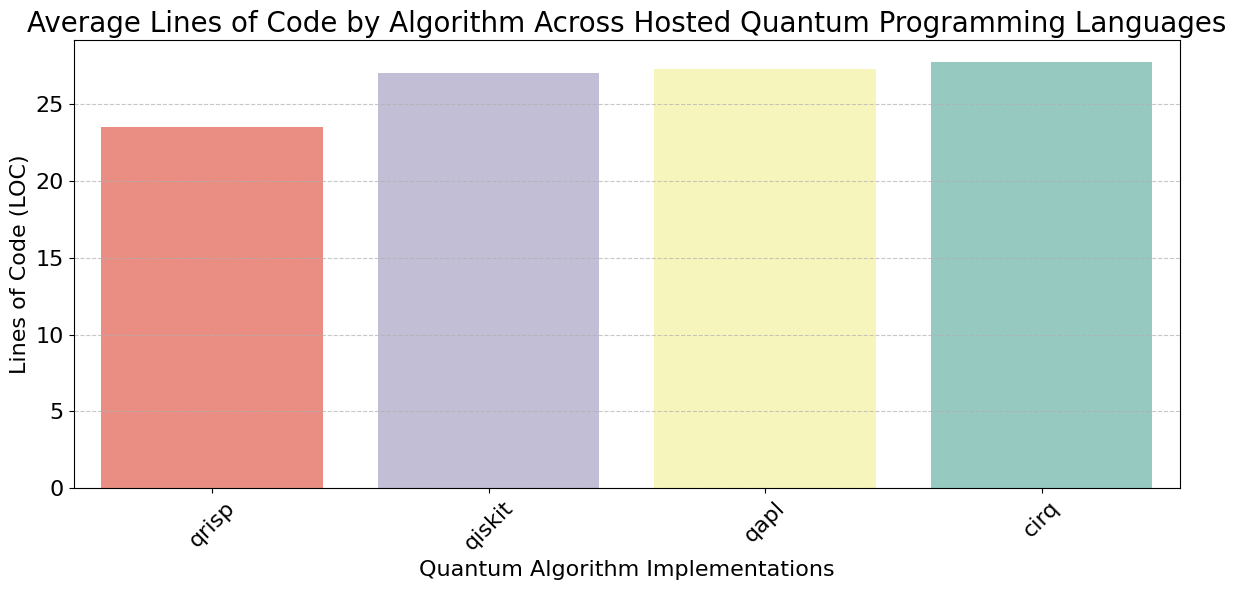

C:\Users\franc\AppData\Local\Temp\ipykernel_29980\1368862335.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


Plot saved at: results/graphics/Average Lines of Code by Algorithm Across Standalone Quantum Programming Languages.png


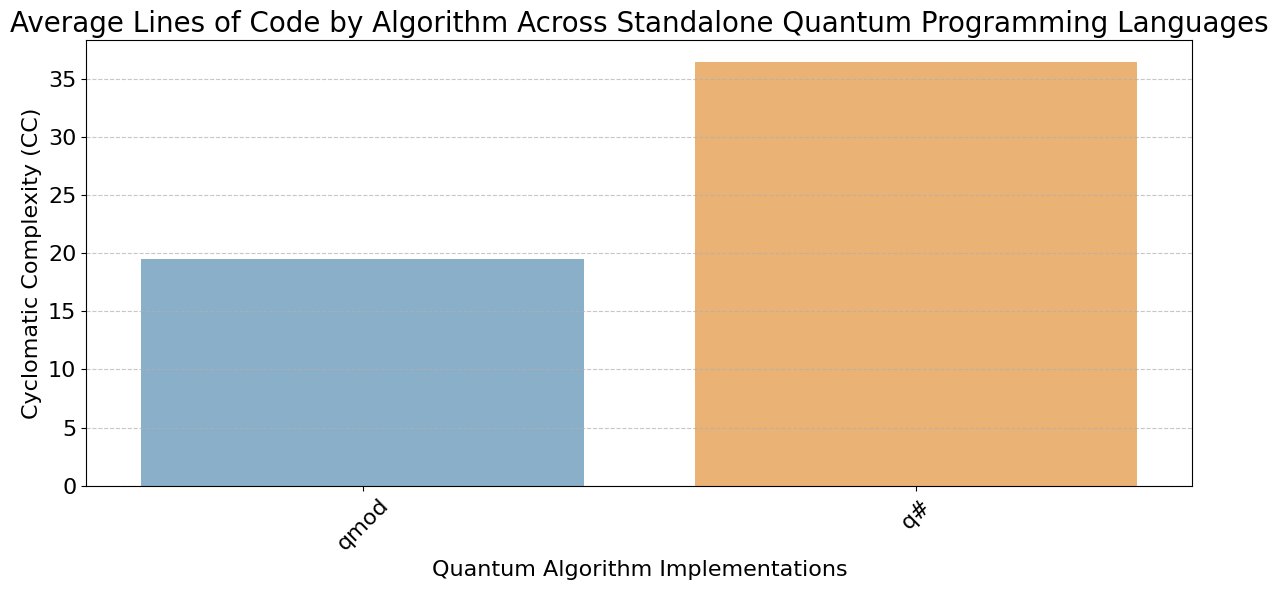

C:\Users\franc\AppData\Local\Temp\ipykernel_29980\1368862335.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


Plot saved at: results/graphics/Average Lines of Code by Algorithm Across Quantum Programming Languages.png


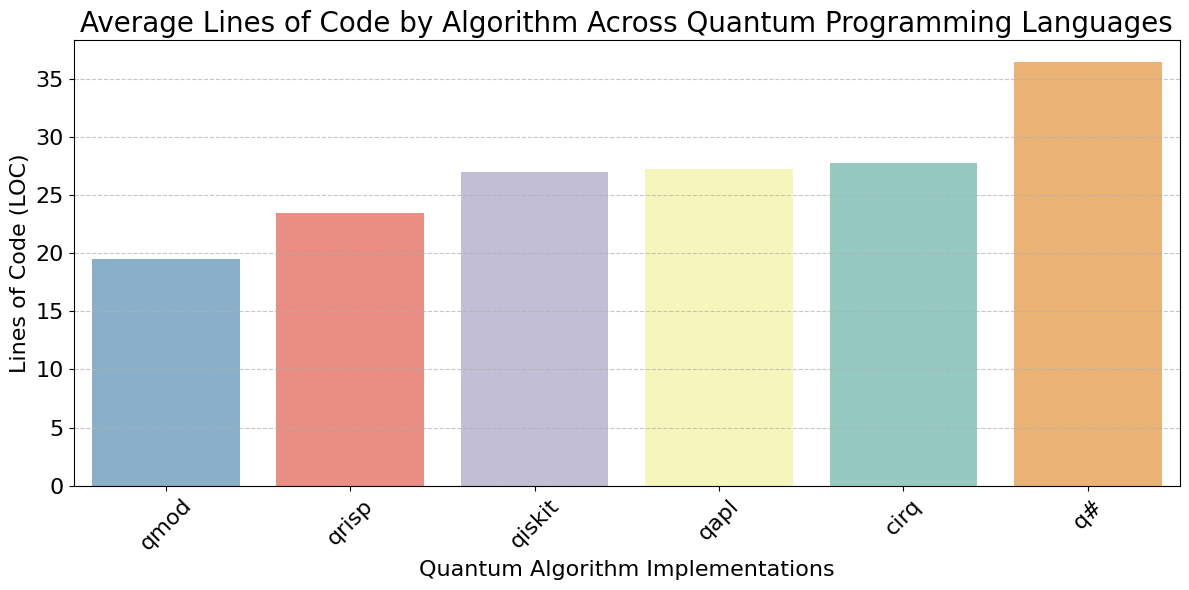

C:\Users\franc\AppData\Local\Temp\ipykernel_29980\1368862335.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


Plot saved at: results/graphics/Average Cyclomatic Complexity by Algorithm Across Hosted Quantum Programming Languages.png


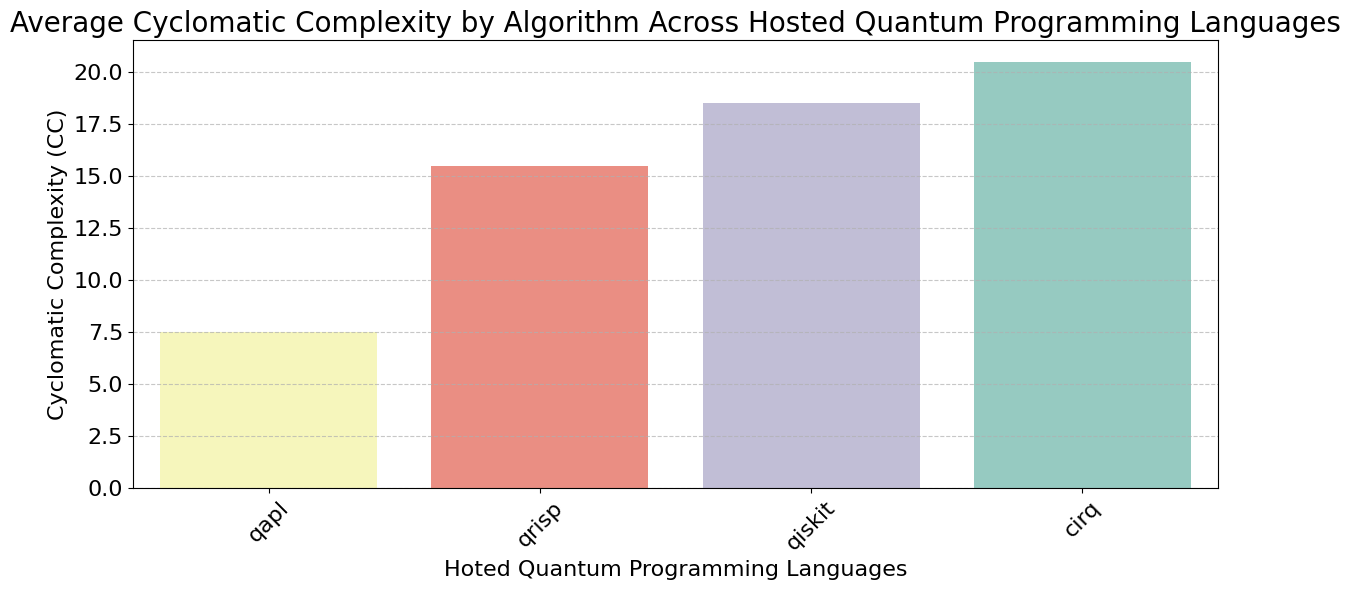

Plot saved at: results/graphics/Average Cyclomatic Complexity by Algorithm Across Standalone Quantum Programming Languages.png


C:\Users\franc\AppData\Local\Temp\ipykernel_29980\1368862335.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


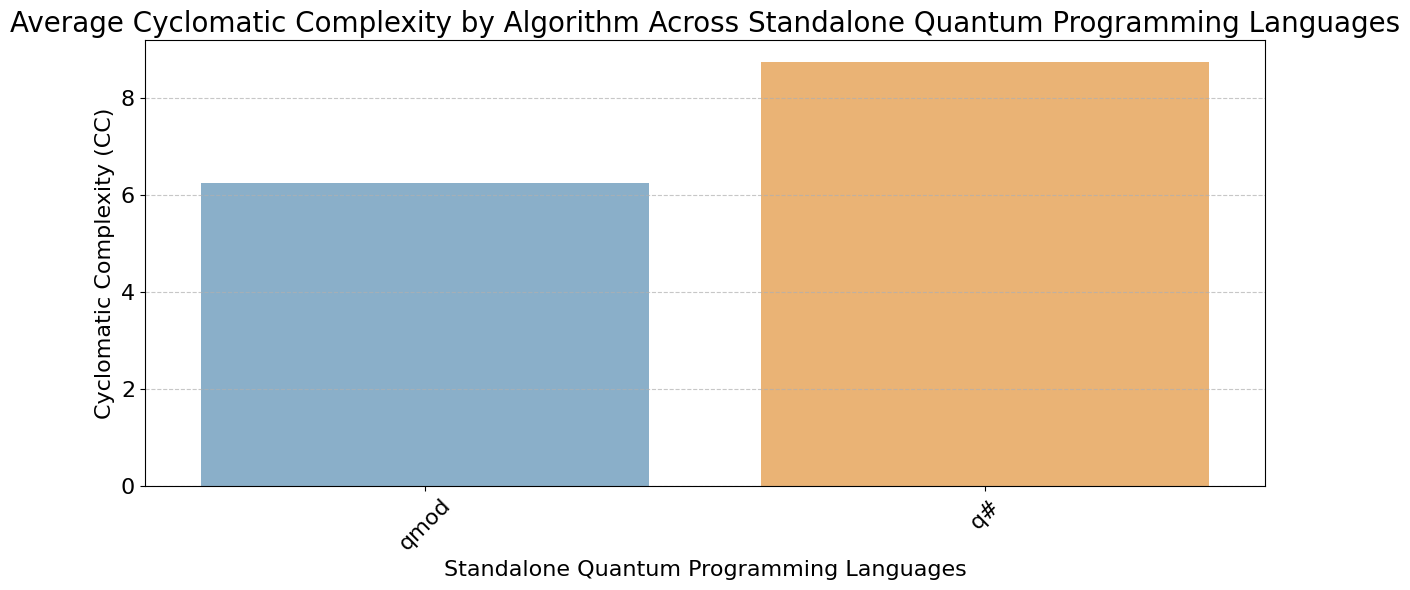

C:\Users\franc\AppData\Local\Temp\ipykernel_29980\1368862335.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


Plot saved at: results/graphics/Average by Algorithm Across Quantum Programming Languages.png


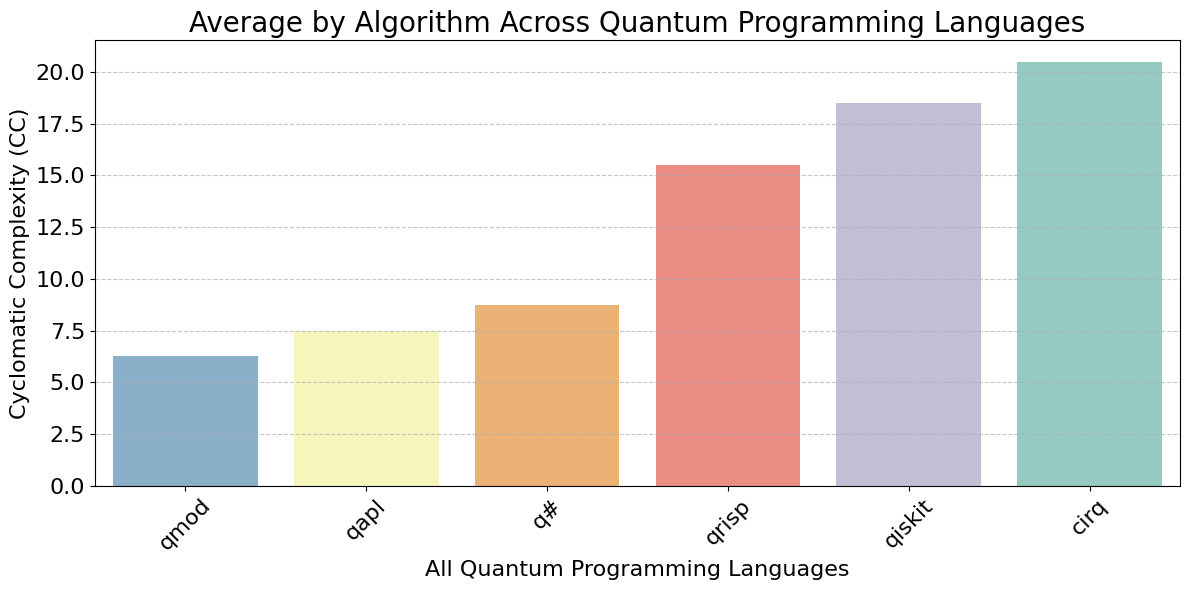

In [1183]:

analyzer.run(language_type="all", chart_type=["loc_by_algorithm"], attributes={'title': 'Lines of Code by Algorithm in Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Lines of Code (LOC)',})

analyzer.run(language_type="all", chart_type=["cc_by_algorithm"], attributes={'title': 'Cyclomatic Complexity by Algorithm in Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Cyclomatic Complexity (CC)',})


# Lines of code by algorithm across hosted quantum programming languages
analyzer.run(language_type="hosted", chart_type=["loc_by_algorithm"], attributes={'title': 'Lines of Code by Algorithm Across Hosted Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Lines of Code (LOC)',})

analyzer.run(language_type="standalone", chart_type=["loc_by_algorithm"], attributes={'title': 'Lines of Code by Algorithm Across Standalone Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Lines of Code (LOC)',})

# Cyclomatic complexity by algorithm across hosted quantum programming languages
analyzer.run(language_type="hosted", chart_type=["cc_by_algorithm"], attributes={'title': 'Cyclomatic Complexity by Algorithm  Across Hosted Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Cyclomatic Complexity (CC)',})

analyzer.run(language_type="standalone", chart_type=["cc_by_algorithm"], attributes={'title': 'Cyclomatic Complexity by Algorithm Across Standalone Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Cyclomatic Complexity (CC)',})


# Average LOC by algorithm across hosted quantum programming languages
analyzer.run(language_type="hosted", chart_type=["loc_avg_by_algorithm"], attributes={'title': 'Average Lines of Code by Algorithm Across Hosted Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Lines of Code (LOC)',})
analyzer.run(language_type="standalone", chart_type=["loc_avg_by_algorithm"], attributes={'title': 'Average Lines of Code by Algorithm Across Standalone Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Cyclomatic Complexity (CC)',})
analyzer.run(language_type="all", chart_type=["loc_avg_by_algorithm"], attributes={'title': 'Average Lines of Code by Algorithm Across Quantum Programming Languages',
                                                                                'xlabel': 'Quantum Algorithm Implementations',
                                                                                'ylabel': 'Lines of Code (LOC)',})


# Average CC by algorithm across hosted quantum programming languages
analyzer.run(language_type="hosted", chart_type=["cc_avg_by_algorithm"], attributes={'title': 'Average Cyclomatic Complexity by Algorithm Across Hosted Quantum Programming Languages',
                                                                                'xlabel': 'Hoted Quantum Programming Languages',
                                                                                'ylabel': 'Cyclomatic Complexity (CC)',})
analyzer.run(language_type="standalone", chart_type=["cc_avg_by_algorithm"], attributes={'title': 'Average Cyclomatic Complexity by Algorithm Across Standalone Quantum Programming Languages',
                                                                                'xlabel': 'Standalone Quantum Programming Languages',
                                                                                'ylabel': 'Cyclomatic Complexity (CC)',})
analyzer.run(language_type="all", chart_type=["cc_avg_by_algorithm"], attributes={'title': 'Average by Algorithm Across Quantum Programming Languages',
                                                                                'xlabel': 'All Quantum Programming Languages',
                                                                                'ylabel': 'Cyclomatic Complexity (CC)',})

Plot saved at: results/graphics/Complexity Metrics for Hosted Quantum Programming Languages.png


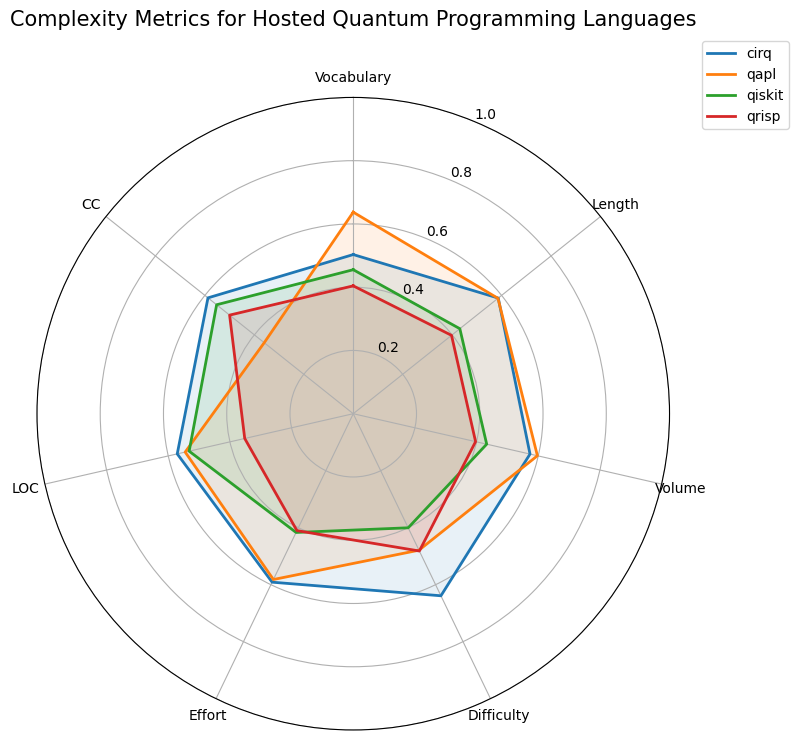

Plot saved at: results/graphics/Complexity Metrics for Standalone Quantum Programming Languages.png


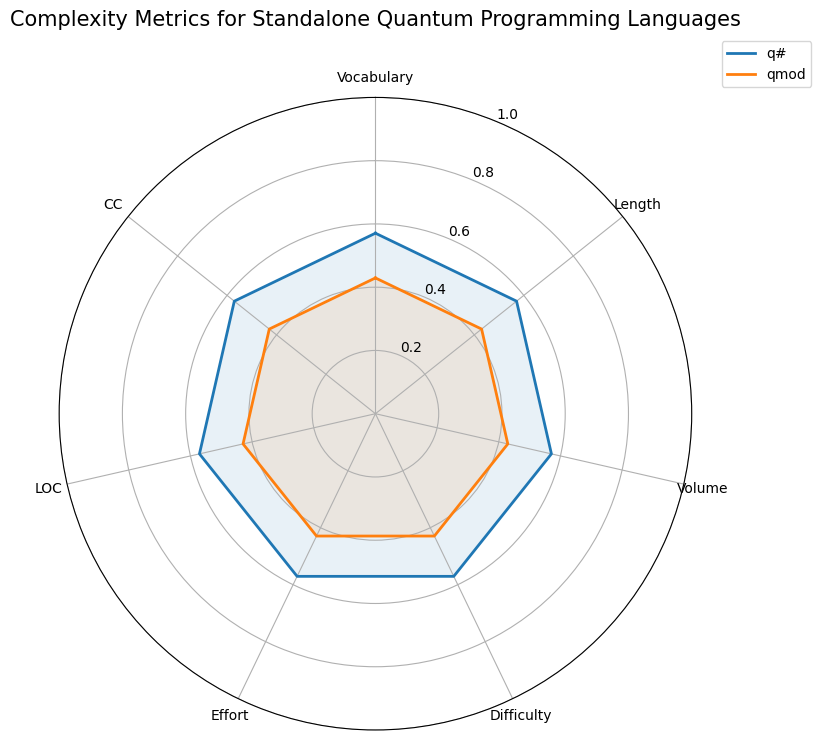

Plot saved at: results/graphics/Complexity Metrics for Quantum Programming Languages.png


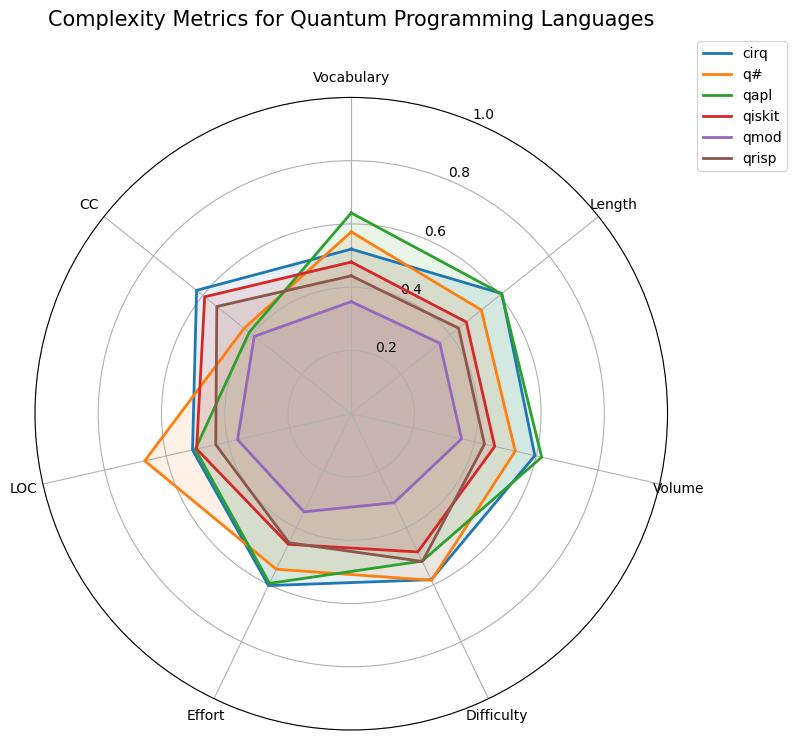

In [1179]:
analyzer.run(language_type="hosted", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Hosted Quantum Programming Languages'})
analyzer.run(language_type="standalone", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Standalone Quantum Programming Languages'})
analyzer.run(language_type="all", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Quantum Programming Languages'})

Plot saved at: results/graphics/Lines of Code vs Cyclomatic Complexity Across Quantum Programming Languages.png


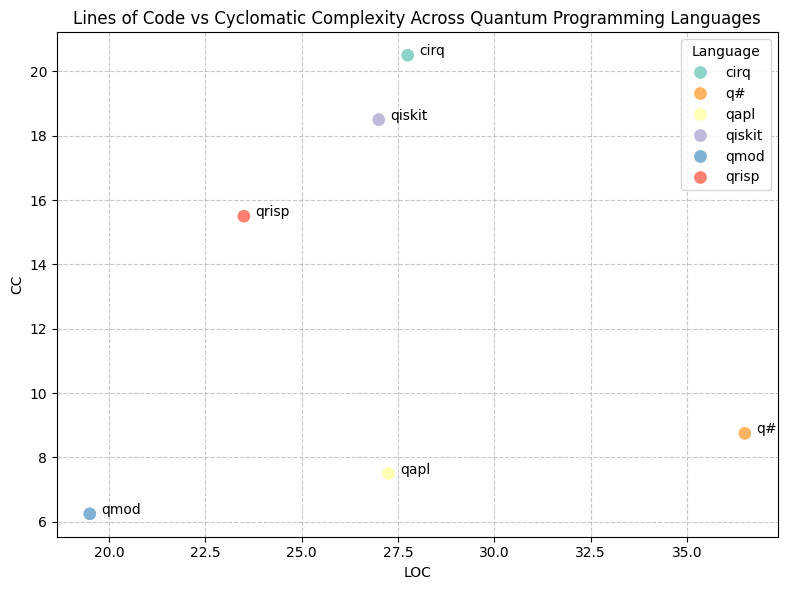

In [1180]:
analyzer.run(language_type="all", chart_type=["loc_vs_cc"], attributes={"title": "Lines of Code vs Cyclomatic Complexity Across Quantum Programming Languages"})

Plot saved at: results/graphics/10_scatter_matrix_metrics.png


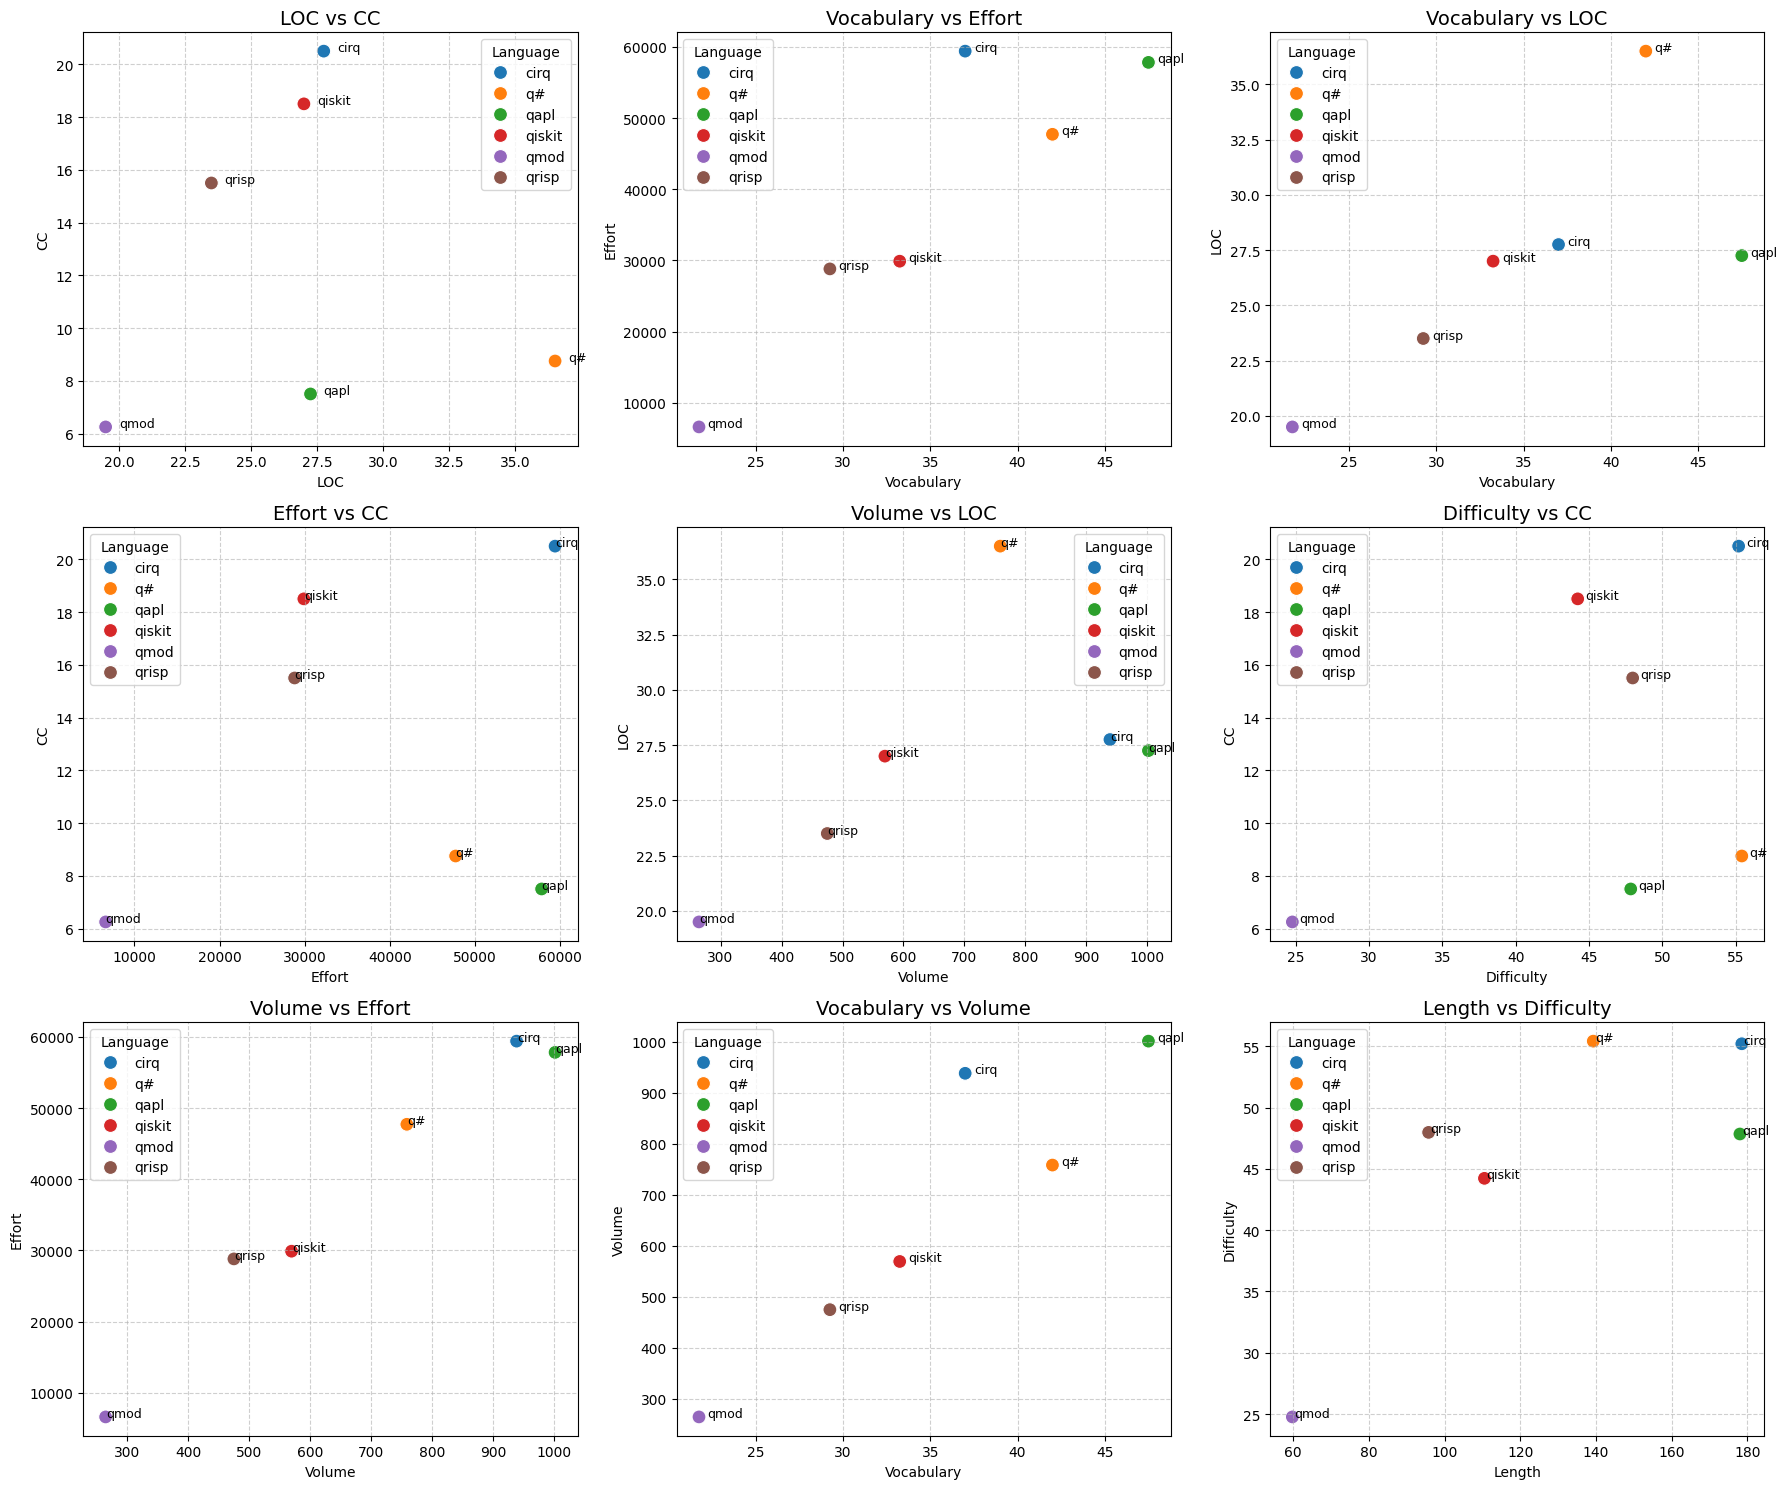

In [1181]:
analyzer.run(language_type="all", chart_type="scatter_matrix")
